In [1]:
import os
import os
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input, Model
from keras.applications import InceptionResNetV2
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, Flatten, Dense, BatchNormalization, Reshape, concatenate, LeakyReLU, Lambda, Activation, UpSampling2D, Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras_preprocessing import image
from scipy.io import loadmat
from keras import layers
from sklearn.model_selection import train_test_split

In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jangedoo/utkface-new")


100%|██████████| 331M/331M [00:04<00:00, 83.0MB/s]


In [4]:
from pathlib import Path
from PIL import Image

ages=[]
genders=[]
races = []
imgs = []
original_img = []
files =Path('/content/utkface-new/UTKFace').glob('*')
for myFile in files:
  img_name = str(myFile)[29:]
  age_gender_ethnicity = img_name.split('_')
  if len(age_gender_ethnicity) == 4 :
    ages.append(int(age_gender_ethnicity[0]))
    genders.append(int(age_gender_ethnicity[1]))
    races.append(int(age_gender_ethnicity[2]))
    img=Image.open(myFile)
    original_img.append(np.array(img))
    img = img.convert('RGB')
    img=img.resize((64,64))
    
    img=np.array(img)
    # img = img/255
    imgs.append(img)

In [5]:
imgs_ = np.array(imgs)[:2000]
imgs_.shape

(2000, 64, 64, 3)

In [6]:
for i in range(len(ages)):
  if ages[i]<=18:
    ages[i] = 0
  if ages[i]>18 and ages[i] <= 29:
    ages[i] = 1
  if ages[i]>29 and ages[i] <= 39:
    ages[i] = 2
  if ages[i]>39 and ages[i] <= 49:
    ages[i] = 3
  if ages[i]>49 and ages[i] <= 59:
    ages[i] = 4
  if ages[i]>=60:
    ages[i] = 5




In [7]:
ages_ = np.array(ages)[:2000]
ages_.shape

(2000,)

In [8]:
x_train, x_test, age_y_train, age_y_test = train_test_split(imgs_, ages_,test_size=0.05,random_state=45)

In [9]:
def build_encoder():
    """
    Encoder Network
    """
    input_layer = Input(shape=(64, 64, 3))

    # 1st Convolutional Block
    enc = Conv2D(filters=32, kernel_size=5, strides=2, padding='same')(input_layer)
    # enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)

    # 2nd Convolutional Block
    enc = Conv2D(filters=64, kernel_size=5, strides=2, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)

    # 3rd Convolutional Block
    enc = Conv2D(filters=128, kernel_size=5, strides=2, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)

    # 4th Convolutional Block
    enc = Conv2D(filters=256, kernel_size=5, strides=2, padding='same')(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)

    # Flatten layer
    enc = Flatten()(enc)

    # 1st Fully Connected Layer
    enc = Dense(4096)(enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU(alpha=0.2)(enc)

    # Second Fully Connected Layer
    enc = Dense(100)(enc)

    # Create a model
    model = Model(inputs=[input_layer], outputs=[enc])
    return model

In [10]:
def build_generator():
    """
    Create a Generator Model with hyperparameters values defined as follows
    """
    latent_dims = 100
    num_classes = 6

    input_z_noise = Input(shape=(latent_dims,))
    input_label = Input(shape=(num_classes,))

    x = concatenate([input_z_noise, input_label])

    x = Dense(2048, input_dim=latent_dims + num_classes)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)

    x = Dense(256 * 8 * 8)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.2)(x)

    x = Reshape((8, 8, 256))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters=128, kernel_size=5, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters=64, kernel_size=5, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters=3, kernel_size=5, padding='same')(x)
    x = Activation('tanh')(x)

    model = Model(inputs=[input_z_noise, input_label], outputs=[x])
    return model

In [11]:
def expand_label_input(x):
    x = K.expand_dims(x, axis=1)
    x = K.expand_dims(x, axis=1)
    x = K.tile(x, [1, 32, 32, 1])
    return x

In [12]:
def build_discriminator():
    """
    Create a Discriminator Model with hyperparameters values defined as follows
    """
    input_shape = (64, 64, 3)
    label_shape = (6,)
    image_input = Input(shape=input_shape)
    label_input = Input(shape=label_shape)

    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(image_input)
    x = LeakyReLU(alpha=0.2)(x)

    label_input1 = Lambda(expand_label_input)(label_input)
    x = concatenate([x, label_input1], axis=3)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[image_input, label_input], outputs=[x])
    return model

In [13]:
def build_fr_combined_network(encoder, generator, fr_model):
    input_image = Input(shape=(64, 64, 3))
    input_label = Input(shape=(6,))

    latent0 = encoder(input_image)

    gen_images = generator([latent0, input_label])

    fr_model.trainable = False

    resized_images = Lambda(lambda x: K.resize_images(gen_images, height_factor=2, width_factor=2,
                                                      data_format='channels_last'))(gen_images)
    embeddings = fr_model(resized_images)

    model = Model(inputs=[input_image, input_label], outputs=[embeddings])
    return model

In [14]:
def build_fr_model(input_shape):
    resent_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    image_input = resent_model.input
    x = resent_model.layers[-1].output
    out = Dense(128)(x)
    embedder_model = Model(inputs=[image_input], outputs=[out])

    input_layer = Input(shape=input_shape)

    x = embedder_model(input_layer)
    output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(x)

    model = Model(inputs=[input_layer], outputs=[output])
    return model

In [15]:
#resize the images from a shape of (64, 64, 3) to a shape of (192, 192, 3)
def build_image_resizer():
    input_layer = Input(shape=(64, 64, 3))

    resized_images = Lambda(lambda x: K.resize_images(x, height_factor=3, width_factor=3,
                                                      data_format='channels_last'))(input_layer)

    model = Model(inputs=[input_layer], outputs=[resized_images])
    return model


def calculate_age(taken, dob):
    birth = datetime.fromordinal(max(int(dob) - 366, 1))

    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [16]:
def load_data(wiki_dir, dataset='wiki'):
    # Load the wiki.mat file
    meta = loadmat(os.path.join(wiki_dir, "{}.mat".format(dataset)))

    # Load the list of all files
    full_path = meta[dataset][0, 0]["full_path"][0]

    # List of Matlab serial date numbers
    dob = meta[dataset][0, 0]["dob"][0]

    # List of years when photo was taken
    photo_taken = meta[dataset][0, 0]["photo_taken"][0]  # year

    # Calculate age for all dobs
    age = [calculate_age(photo_taken[i], dob[i]) for i in range(len(dob))]

    # Create a list of tuples containing a pair of an image path and age
    images = []
    age_list = []
    for index, image_path in enumerate(full_path):
        images.append(image_path[0])
        age_list.append(age[index])

    # Return a list of all images and respective age
    return images, age_list

In [17]:
def age_to_category(age_list):
    print("age_to_category age_list size : " + str(len(age_list[:1000])))
    age_list1 = []

    for age in age_list:
        if 0 < age <= 18:
            age_category = 0
        elif 18 < age <= 29:
            age_category = 1
        elif 29 < age <= 39:
            age_category = 2
        elif 39 < age <= 49:
            age_category = 3
        elif 49 < age <= 59:
            age_category = 4
        elif age >= 60:
            age_category = 5

        age_list1.append(age_category)

    return age_list1

In [18]:
def load_images(data_dir, image_paths, image_shape):
    images = None
    for i, image_path in enumerate(image_paths):
        print("index i : " + str(i) + " and image path : " + str(image_path))
        try:
            # Load image
            loaded_image = image.load_img(os.path.join(data_dir, image_path), target_size=image_shape)

            # Convert PIL image to numpy ndarray
            loaded_image = image.img_to_array(loaded_image)

            # Add another dimension (Add batch dimension)
            loaded_image = np.expand_dims(loaded_image, axis=0)

            # Concatenate all images into one tensor
            if images is None:
                images = loaded_image
            else:
                images = np.concatenate([images, loaded_image], axis=0)
        except Exception as e:
            print("Error:", i, e)

    return images

In [19]:
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))


def write_log(callback, name, value, batch_no):
    summary = tf.summary()
    summary_value = summary.value.add()
    summary_value.simple_value = value
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()

def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

In [ ]:
if __name__ == '__main__':
    # Define hyperparameters
    # data_dir = "./data"
    # wiki_dir = os.path.join(data_dir, "wiki_crop")
    #epochs = 500
    epochs = 500
    batch_size = 128
    image_shape = (64, 64, 3)
    z_shape = 100
    TRAIN_GAN = True
    TRAIN_ENCODER = True
    TRAIN_GAN_WITH_FR = True
    fr_image_shape = (192, 192, 3)

    # Define optimizers
    # Optimizer for the discriminator network
    dis_optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=10e-8)
    # Optimizer for the generator network
    gen_optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=10e-8)
    # Optimizer for the adversarial network
    adversarial_optimizer = Adam(lr=0.0002, beta_1=0.5, beta_2=0.999, epsilon=10e-8)

    """
    Build and compile networks
    """
    # Build and compile the discriminator network
    discriminator = build_discriminator()
    discriminator.compile(loss=['binary_crossentropy'], optimizer=dis_optimizer)

    # Build and compile the generator network
    generator = build_generator()
    generator.compile(loss=['binary_crossentropy'], optimizer=gen_optimizer)

    # Build and compile the adversarial model
    # discriminator.trainable = False
    input_z_noise = Input(shape=(100,))
    input_label = Input(shape=(6,))
    recons_images = generator([input_z_noise, input_label])
    valid = discriminator([recons_images, input_label])
    adversarial_model = Model(inputs=[input_z_noise, input_label], outputs=[valid])
    adversarial_model.compile(loss=['binary_crossentropy'], optimizer=gen_optimizer)

    tensorboard = TensorBoard(log_dir="logs/{}".format(time.time()))
    tensorboard.set_model(generator)
    tensorboard.set_model(discriminator)

    """
    Load the dataset
    """
    images, age_list = x_train, age_y_train
    print("number of images : "+ str(len(images)))
    print("age_list size : " + str(len(age_list)))
    age_cat = age_list
    final_age_cat = np.reshape(np.array(age_cat), [len(age_cat), 1])
    classes = len(set(age_cat))
    y = to_categorical(final_age_cat, num_classes=len(set(age_cat)))

    loaded_images = images

    # Implement label smoothing
    real_labels = np.ones((batch_size, 1), dtype=np.float32) * 0.9
    fake_labels = np.zeros((batch_size, 1), dtype=np.float32) * 0.1

    """
    Train the generator and the discriminator network
    """
    if TRAIN_GAN:
        for epoch in range(epochs):
            print("Epoch:{}".format(epoch))

            gen_losses = []
            dis_losses = []

            number_of_batches = int(len(loaded_images) / batch_size)
            print("Number of batches:", number_of_batches)
            for index in range(number_of_batches):
                print("Batch:{}".format(index + 1))

                images_batch = loaded_images[index * batch_size:(index + 1) * batch_size]
                images_batch = (images_batch.astype(np.float32)) / 255
                images_batch = images_batch.astype(np.float32)

                y_batch = y[index * batch_size:(index + 1) * batch_size]
                z_noise = np.random.normal(0, 1, size=(batch_size, z_shape))

                """
                Train the discriminator network
                """

                # Generate fake images
                initial_recon_images = generator.predict_on_batch([z_noise, y_batch])

                d_loss_real = discriminator.train_on_batch([images_batch, y_batch], real_labels)
                d_loss_fake = discriminator.train_on_batch([initial_recon_images, y_batch], fake_labels)

                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                print("d_loss:{}".format(d_loss))

                """
                Train the generator network
                """

                z_noise2 = np.random.normal(0, 1, size=(batch_size, z_shape))
                random_labels = np.random.randint(0, 6, batch_size).reshape(-1, 1)
                random_labels = to_categorical(random_labels, 6)

                g_loss = adversarial_model.train_on_batch([z_noise2, random_labels], np.array([1] * batch_size))

                print("g_loss:{}".format(g_loss))

                gen_losses.append(g_loss)
                dis_losses.append(d_loss)

            # Write losses to Tensorboard
            # write_log(tensorboard, 'g_loss', np.mean(gen_losses), epoch)
            # write_log(tensorboard, 'd_loss', np.mean(dis_losses), epoch)

            """
            Generate images after every 10th epoch
            """
            if epoch % 10 == 0:
                images_batch = loaded_images[0:batch_size]
                images_batch = (images_batch.astype(np.float32)) / 255
                images_batch = images_batch.astype(np.float32)

                y_batch = y[0:batch_size]
                z_noise = np.random.normal(0, 1, size=(batch_size, z_shape))

                gen_images = generator.predict_on_batch([z_noise, y_batch])

                for i, img in enumerate(gen_images[:5]):
                    save_rgb_img(img, path="/content/results/img_{}_{}.png".format(epoch, i))

        # Save networks
        try:
            generator.save_weights("generator.h5")
            discriminator.save_weights("discriminator.h5")
        except Exception as e:
            print("Error:", e)

    """
    Train encoder
    """

    if TRAIN_ENCODER:
        # Build and compile encoder
        encoder = build_encoder()
        encoder.compile(loss=euclidean_distance_loss, optimizer='adam')

        # Load the generator network's weights
        try:
            generator.load_weights("generator.h5")
        except Exception as e:
            print("Error:", e)

        z_i = np.random.normal(0, 1, size=(200, z_shape))

        y = np.random.randint(low=0, high=6, size=(200,), dtype=np.int64)
        num_classes = len(set(y))
        y = np.reshape(np.array(y), [len(y), 1])
        y = to_categorical(y, num_classes=num_classes)

        for epoch in range(epochs):
            print("Epoch:", epoch)

            encoder_losses = []

            number_of_batches = int(z_i.shape[0] / batch_size)
            print("Number of batches:", number_of_batches)
            for index in range(number_of_batches):
                print("Batch:", index + 1)

                z_batch = z_i[index * batch_size:(index + 1) * batch_size]
                y_batch = y[index * batch_size:(index + 1) * batch_size]

                generated_images = generator.predict_on_batch([z_batch, y_batch])

                # Train the encoder model
                encoder_loss = encoder.train_on_batch(generated_images, z_batch)
                print("Encoder loss:", encoder_loss)

                encoder_losses.append(encoder_loss)

            # Write the encoder loss to Tensorboard
            # write_log(tensorboard, "encoder_loss", np.mean(encoder_losses), epoch)

        # Save the encoder model
        encoder.save_weights("encoder.h5")

    """
    Optimize the encoder and the generator network
    """
    if TRAIN_GAN_WITH_FR:

        # Load the encoder network
        encoder = build_encoder()
        encoder.load_weights("encoder.h5")

        # Load the generator network
        generator.load_weights("generator.h5")

        image_resizer = build_image_resizer()
        image_resizer.compile(loss=['binary_crossentropy'], optimizer='adam')

        # Face recognition model
        fr_model = build_fr_model(input_shape=fr_image_shape)
        fr_model.compile(loss=['binary_crossentropy'], optimizer="adam")

        # Make the face recognition network as non-trainable
        fr_model.trainable = False

        # Input layers
        input_image = Input(shape=(64, 64, 3))
        input_label = Input(shape=(6,))

        # Use the encoder and the generator network
        latent0 = encoder(input_image)
        gen_images = generator([latent0, input_label])

        # Resize images to the desired shape
        resized_images = image_resizer(gen_images)
        embeddings = fr_model(resized_images)

        # Create a Keras model and specify the inputs and outputs for the network
        fr_adversarial_model = Model(inputs=[input_image, input_label], outputs=[embeddings])

        # Compile the model
        fr_adversarial_model.compile(loss=euclidean_distance_loss, optimizer=adversarial_optimizer)

        for epoch in range(epochs):
            print("Epoch:", epoch)

            reconstruction_losses = []

            number_of_batches = int(len(loaded_images) / batch_size)
            print("Number of batches:", number_of_batches)
            for index in range(number_of_batches):
                print("Batch:", index + 1)

                images_batch = loaded_images[index * batch_size:(index + 1) * batch_size]
                images_batch = (images_batch.astype(np.float32)) / 255

                y_batch = y[index * batch_size:(index + 1) * batch_size]

                images_batch_resized = image_resizer.predict_on_batch(images_batch)

                real_embeddings = fr_model.predict_on_batch(images_batch_resized)

                reconstruction_loss = fr_adversarial_model.train_on_batch([images_batch, y_batch], real_embeddings)

                print("Reconstruction loss:", reconstruction_loss)

                reconstruction_losses.append(reconstruction_loss)

            # Write the reconstruction loss to Tensorboard
            # write_log(tensorboard, "reconstruction_loss", np.mean(reconstruction_losses), epoch)

            """
            Generate images
            """
            if epoch % 10 == 0:
                images_batch = loaded_images[0:batch_size]
                images_batch = (images_batch.astype(np.float32)) / 255
                # images_batch = images_batch.astype(np.float32)

                y_batch = y[0:batch_size]
                z_noise = encoder.predict_on_batch(images_batch)

                gen_images = generator.predict_on_batch([z_noise, y_batch])

                for i, img in enumerate(gen_images[:5]):
                    save_rgb_img(img, path="/content/results/img_opt_{}_{}.png".format(epoch, i))

        # Save improved weights for both of the networks
        generator.save_weights("generator_optimized.h5")
        encoder.save_weights("encoder_optimized.h5")


number of images : 1900
age_list size : 1900
Epoch:0
Number of batches: 14
Batch:1
d_loss:1.780940681695938
g_loss:0.6200419664382935
Batch:2
d_loss:1.1579669117927551
g_loss:0.3773154020309448
Batch:3
d_loss:0.4603889286518097
g_loss:0.18198630213737488
Batch:4
d_loss:0.33424295485019684
g_loss:0.051603544503450394
Batch:5
d_loss:0.26543542742729187
g_loss:0.008455498144030571
Batch:6
d_loss:0.21691256761550903
g_loss:0.0028882778715342283
Batch:7
d_loss:0.1964465230703354
g_loss:0.0014615280088037252
Batch:8
d_loss:0.1896686078980565
g_loss:0.0011995435925200582
Batch:9
d_loss:0.17883867165073752
g_loss:0.0011555114760994911
Batch:10
d_loss:0.17535211751237512
g_loss:0.0009500537416897714
Batch:11
d_loss:0.17837419733405113
g_loss:0.0009261416853405535
Batch:12
d_loss:0.18175607547163963
g_loss:0.0006678092177025974
Batch:13
d_loss:0.17356301471590996
g_loss:0.0009394835215061903
Batch:14
d_loss:0.17251813132315874


g_loss:0.0006677421624772251
Epoch:1
Number of batches: 14
Batch:1
d_loss:0.17470545112155378
g_loss:0.0008219720330089331
Batch:2
d_loss:0.17338614678010345
g_loss:0.0006423562299460173
Batch:3
d_loss:0.17496703437063843
g_loss:0.0006792752537876368
Batch:4
d_loss:0.1704982416704297
g_loss:0.0007339639705605805
Batch:5
d_loss:0.17900530924089253
g_loss:0.0006624326342716813
Batch:6
d_loss:0.1846094090724364
g_loss:0.000553075922653079
Batch:7
d_loss:0.18961497384589165
g_loss:0.0007854911964386702
Batch:8
d_loss:0.18081452115438879
g_loss:0.0006277193897403777
Batch:9
d_loss:0.1735960888909176
g_loss:0.0005844996776431799
Batch:10
d_loss:0.17719675600528717
g_loss:0.0005071924533694983
Batch:11
d_loss:0.16943184996489435
g_loss:0.0005900232354179025
Batch:12
d_loss:0.17512742331018671
g_loss:0.0005273798597045243
Batch:13
d_loss:0.17928526096511632
g_loss:0.0005033079069107771
Batch:14
d_loss:0.20411297294776887
g_loss:0.00041008280823007226
Epoch:2
Number of batches: 14
Batch:1
d_los

d_loss:0.16873305849730968
g_loss:0.00012471777154132724


Epoch:11
Number of batches: 14
Batch:1
d_loss:0.16535616081091575
g_loss:8.994853851618245e-05
Batch:2
d_loss:0.1669136344717117
g_loss:0.00010797179129440337
Batch:3
d_loss:0.16430555065744556
g_loss:7.794723933329806e-05
Batch:4
d_loss:0.1639448403584538
g_loss:9.91347769740969e-05
Batch:5
d_loss:0.1638065740262391
g_loss:6.961839972063899e-05
Batch:6
d_loss:0.165037695915089
g_loss:0.00010194261994911358
Batch:7
d_loss:0.16599120807950385
g_loss:5.928793325438164e-05
Batch:8
d_loss:0.16862195704015903
g_loss:8.66681439219974e-05
Batch:9
d_loss:0.1636501266475534
g_loss:8.583611634094268e-05
Batch:10
d_loss:0.16377289264346473
g_loss:7.624294812558219e-05
Batch:11
d_loss:0.1642291794414632
g_loss:0.00012403345317579806
Batch:12
d_loss:0.16445332681178115
g_loss:5.9704118029912934e-05
Batch:13
d_loss:0.16651904700847808
g_loss:0.00010654525249265134
Batch:14
d_loss:0.16617547589703463
g_loss:4.618980165105313e-05
Epoch:12
Number of batches: 14
Batch:1
d_loss:0.17037933535175398
g_loss

d_loss:0.16694607250974514
g_loss:4.8801302909851074e-05


Epoch:21
Number of batches: 14
Batch:1
d_loss:0.165634903452883
g_loss:2.3655582481296733e-05
Batch:2
d_loss:0.1695040023769252
g_loss:5.066008088761009e-05
Batch:3
d_loss:0.16521776033914648
g_loss:3.2297230063704774e-05
Batch:4
d_loss:0.16471054941939656
g_loss:5.1566792535595596e-05
Batch:5
d_loss:0.16324899603932863
g_loss:4.0833801904227585e-05
Batch:6
d_loss:0.16394410890643485
g_loss:5.290466651786119e-05
Batch:7
d_loss:0.16485407513391692
g_loss:2.8139595087850466e-05
Batch:8
d_loss:0.16790693173243199
g_loss:6.0961610870435834e-05
Batch:9
d_loss:0.16604501099936897
g_loss:3.0462342692771927e-05
Batch:10
d_loss:0.16834667169314343
g_loss:6.315645441645756e-05
Batch:11
d_loss:0.16671859023335855
g_loss:2.797513297991827e-05
Batch:12
d_loss:0.16701373288378818
g_loss:4.866067320108414e-05
Batch:13
d_loss:0.1638724085642025
g_loss:4.045764580951072e-05
Batch:14
d_loss:0.16437749976466876
g_loss:4.757376154884696e-05
Epoch:22
Number of batches: 14
Batch:1
d_loss:0.16380530087189982

d_loss:0.16698384190385696
g_loss:5.512655479833484e-05


Epoch:31
Number of batches: 14
Batch:1
d_loss:0.1712295489414828
g_loss:0.0001120271481340751
Batch:2
d_loss:0.16626304104283918
g_loss:4.4152766349725425e-05
Batch:3
d_loss:0.16983223374700174
g_loss:8.835751214064658e-05
Batch:4
d_loss:0.164999899599934
g_loss:6.841721187811345e-05
Batch:5
d_loss:0.1635086829046486
g_loss:7.555002230219543e-05
Batch:6
d_loss:0.1634108722792007
g_loss:8.298587636090815e-05
Batch:7
d_loss:0.16317630422418006
g_loss:8.052145130932331e-05
Batch:8
d_loss:0.1632958726695506
g_loss:7.800849562045187e-05
Batch:9
d_loss:0.16352507246483583
g_loss:6.996094452915713e-05
Batch:10
d_loss:0.1647500043909531
g_loss:0.00012228757259435952
Batch:11
d_loss:0.16616927116410807
g_loss:5.489024624694139e-05
Batch:12
d_loss:0.17066408868413419
g_loss:0.0001291304361075163
Batch:13
d_loss:0.16564177399413893
g_loss:7.26042635506019e-05
Batch:14
d_loss:0.16614848701283336
g_loss:0.00014072922931518406
Epoch:32
Number of batches: 14
Batch:1
d_loss:0.1640123649558518
g_loss:0

g_loss:0.5441545844078064
Epoch:41
Number of batches: 14
Batch:1
d_loss:0.533198818564415
g_loss:1.1861028671264648
Batch:2
d_loss:0.5550689846277237
g_loss:2.2497143745422363
Batch:3
d_loss:0.9007847309112549
g_loss:3.6738295555114746
Batch:4
d_loss:1.1312349736690521
g_loss:3.812499523162842
Batch:5
d_loss:0.5899714976549149
g_loss:1.5237488746643066
Batch:6
d_loss:0.9530055224895477
g_loss:0.6308335065841675
Batch:7
d_loss:0.5723747611045837
g_loss:0.9889709949493408
Batch:8
d_loss:0.4263625144958496
g_loss:0.9179995059967041
Batch:9
d_loss:0.4158540666103363
g_loss:0.3257247805595398
Batch:10
d_loss:0.3097720146179199
g_loss:0.05728666111826897
Batch:11
d_loss:0.2631663829088211
g_loss:0.04192481189966202
Batch:12
d_loss:0.23095965385437012
g_loss:0.01475602202117443
Batch:13
d_loss:0.19244524743407965
g_loss:0.016488051041960716
Batch:14
d_loss:0.21158427372574806
g_loss:0.03250132501125336
Epoch:42
Number of batches: 14
Batch:1
d_loss:0.24891694076359272
g_loss:0.0183838866651058

g_loss:1.3920540809631348
Epoch:51
Number of batches: 14
Batch:1
d_loss:1.2200452089309692
g_loss:0.07803428173065186
Batch:2
d_loss:0.23578906059265137
g_loss:0.5232691764831543
Batch:3
d_loss:0.26287172734737396
g_loss:0.02856062538921833
Batch:4
d_loss:0.24872023612260818
g_loss:0.1531948447227478
Batch:5
d_loss:0.23297490179538727
g_loss:0.02412956766784191
Batch:6
d_loss:0.21217502653598785
g_loss:0.11374778300523758
Batch:7
d_loss:0.6733443140983582
g_loss:0.03829784318804741
Batch:8
d_loss:0.2698405459523201
g_loss:0.8077347278594971
Batch:9
d_loss:0.2920657843351364
g_loss:0.15285980701446533
Batch:10
d_loss:0.23248868435621262
g_loss:0.05951972305774689
Batch:11
d_loss:0.218153927475214
g_loss:0.030507493764162064
Batch:12
d_loss:0.7938268184661865
g_loss:0.03284545987844467
Batch:13
d_loss:0.2464631237089634
g_loss:1.6253986358642578
Batch:14
d_loss:0.212725049816072
g_loss:0.13332870602607727
Epoch:52
Number of batches: 14
Batch:1
d_loss:0.17989481054246426
g_loss:0.03930940

g_loss:0.8003832101821899


Epoch:61
Number of batches: 14
Batch:1
d_loss:0.30747014470398426
g_loss:0.0009329967433586717
Batch:2
d_loss:0.3002243787050247
g_loss:0.005690799094736576
Batch:3
d_loss:0.20709766633808613
g_loss:0.007458349224179983
Batch:4
d_loss:0.20024903304874897
g_loss:0.015153366141021252
Batch:5
d_loss:0.19257423002272844
g_loss:0.201160728931427
Batch:6
d_loss:0.22225403040647507
g_loss:0.0026398510672152042
Batch:7
d_loss:0.213071558624506
g_loss:0.00408264109864831
Batch:8
d_loss:0.23468602821230888
g_loss:0.0069489614106714725
Batch:9
d_loss:0.1899744998663664
g_loss:0.020764317363500595
Batch:10
d_loss:0.20781906973570585
g_loss:0.007850325666368008
Batch:11
d_loss:0.2082437202334404
g_loss:0.009867146611213684
Batch:12
d_loss:0.3020779974758625
g_loss:0.00019764968601521105
Batch:13
d_loss:0.6884557902812958
g_loss:0.446411669254303
Batch:14
d_loss:0.19087483920156956
g_loss:0.04985573887825012
Epoch:62
Number of batches: 14
Batch:1
d_loss:0.7395592629909515
g_loss:0.010438022203743458

g_loss:0.11040446907281876
Epoch:71
Number of batches: 14
Batch:1
d_loss:0.7143376972526312
g_loss:0.0363578163087368
Batch:2
d_loss:0.5740384161472321
g_loss:1.0249178409576416
Batch:3
d_loss:0.26321249907050515
g_loss:1.2591395378112793
Batch:4
d_loss:1.0651476383209229
g_loss:0.30794432759284973
Batch:5
d_loss:0.5281816720962524
g_loss:0.11036239564418793
Batch:6
d_loss:0.23814389295876026
g_loss:0.16226604580879211
Batch:7
d_loss:0.36568035185337067
g_loss:0.0022002635523676872
Batch:8
d_loss:0.5334175825119019
g_loss:0.06460456550121307
Batch:9
d_loss:0.390215165913105
g_loss:0.17663496732711792
Batch:10
d_loss:0.30130353569984436
g_loss:0.025031210854649544
Batch:11
d_loss:0.3175465315580368
g_loss:0.049271903932094574
Batch:12
d_loss:0.7261312305927277
g_loss:0.024127857759594917
Batch:13
d_loss:0.48368218541145325
g_loss:0.08688659220933914
Batch:14
d_loss:0.46953512728214264
g_loss:0.003340361174196005
Epoch:72
Number of batches: 14
Batch:1
d_loss:0.2462669387459755
g_loss:0.0

g_loss:0.01665370911359787
Epoch:81
Number of batches: 14
Batch:1
d_loss:0.18075299100019038
g_loss:0.003914095461368561
Batch:2
d_loss:0.19365756958723068
g_loss:0.0002976001414936036
Batch:3
d_loss:0.1821488724090159
g_loss:0.000978891970589757
Batch:4
d_loss:0.17859014216810465
g_loss:0.0016487437533214688
Batch:5
d_loss:0.18248263816349208
g_loss:0.0009086113423109055
Batch:6
d_loss:0.19269315619021654
g_loss:0.002813962986692786
Batch:7
d_loss:0.17490388033911586
g_loss:0.003263558726757765
Batch:8
d_loss:0.19234634935855865
g_loss:0.00130307930521667
Batch:9
d_loss:0.17763482965528965
g_loss:0.0013881505001336336
Batch:10
d_loss:0.2100903382524848
g_loss:0.00012623443035408854
Batch:11
d_loss:0.20036414032801986
g_loss:0.0005778162740170956
Batch:12
d_loss:0.1794683748157695
g_loss:0.0011666729114949703
Batch:13
d_loss:0.183199193328619
g_loss:0.14615756273269653
Batch:14
d_loss:0.20299885794520378
g_loss:0.053982920944690704
Epoch:82
Number of batches: 14
Batch:1
d_loss:0.177601

d_loss:0.32460861606523395
g_loss:0.1636582314968109


Epoch:91
Number of batches: 14
Batch:1
d_loss:0.253871007822454
g_loss:0.007247010245919228
Batch:2
d_loss:0.3156073372811079
g_loss:0.010556989349424839
Batch:3
d_loss:0.18237660819431767
g_loss:0.26718688011169434
Batch:4
d_loss:0.6045247167348862
g_loss:0.2643973231315613
Batch:5
d_loss:0.2178691104054451
g_loss:0.02602793276309967
Batch:6
d_loss:0.5903806686401367
g_loss:1.1101688146591187
Batch:7
d_loss:0.18324382990249433
g_loss:0.00882672518491745
Batch:8
d_loss:0.23725750856101513
g_loss:0.049882903695106506
Batch:9
d_loss:0.20216549886390567
g_loss:0.010409222915768623
Batch:10
d_loss:0.17800805112347007
g_loss:0.0021054779645055532
Batch:11
d_loss:0.1767577863065526
g_loss:0.02151436358690262
Batch:12
d_loss:0.24457400251412764
g_loss:0.0004849995893891901
Batch:13
d_loss:0.35370833426713943
g_loss:0.0018917135894298553
Batch:14
d_loss:0.21030968392733485
g_loss:0.5846008658409119
Epoch:92
Number of batches: 14
Batch:1
d_loss:0.20161181222647429
g_loss:0.003678213804960251
Ba

Epoch:101
Number of batches: 14
Batch:1
d_loss:0.19105403231515083
g_loss:0.3235971927642822
Batch:2
d_loss:0.21128870826214552
g_loss:0.0006193619919940829
Batch:3
d_loss:0.21036106534302235
g_loss:0.0021428463514894247
Batch:4
d_loss:0.19974285177886486
g_loss:1.5400504707940854e-05
Batch:5
d_loss:0.19455596059560776
g_loss:0.000130822227220051
Batch:6
d_loss:0.1974083762615919
g_loss:0.0013711294159293175
Batch:7
d_loss:0.18964722496457398
g_loss:0.0014175900723785162
Batch:8
d_loss:0.18943391740322113
g_loss:0.00013037525059189647
Batch:9
d_loss:0.1743892829399556
g_loss:0.004077463410794735
Batch:10
d_loss:0.1750546987168491
g_loss:0.0017621198203414679
Batch:11
d_loss:0.17804046627134085
g_loss:0.031920965760946274
Batch:12
d_loss:0.1691433896194212
g_loss:0.0002375929179834202
Batch:13
d_loss:0.20192218013107777
g_loss:5.465983122121543e-05
Batch:14
d_loss:0.17729964386671782
g_loss:0.00028871840913780034
Epoch:102
Number of batches: 14
Batch:1
d_loss:0.17293025075923651
g_loss:

g_loss:0.0013779045548290014


Epoch:111
Number of batches: 14
Batch:1
d_loss:0.19882932119071484
g_loss:0.01690095290541649
Batch:2
d_loss:0.1993063297122717
g_loss:0.0006119266618043184
Batch:3
d_loss:0.18999027367681265
g_loss:0.0003402005531825125
Batch:4
d_loss:0.20242163352668285
g_loss:0.0013209818862378597
Batch:5
d_loss:0.18237921316176653
g_loss:0.01209945697337389
Batch:6
d_loss:0.1948915347456932
g_loss:0.0001017540052998811
Batch:7
d_loss:0.19314438477158546
g_loss:0.7056083679199219
Batch:8
d_loss:0.23187555465847254
g_loss:0.0008853540639393032
Batch:9
d_loss:0.22008396591991186
g_loss:0.06581059098243713
Batch:10
d_loss:0.22879771143198013
g_loss:0.004629477392882109
Batch:11
d_loss:0.2337340973317623
g_loss:0.0028944313526153564
Batch:12
d_loss:0.30588472820818424
g_loss:3.145350638078526e-05
Batch:13
d_loss:0.5535119771957397
g_loss:0.30500465631484985
Batch:14
d_loss:0.2543439455330372
g_loss:0.022798806428909302
Epoch:112
Number of batches: 14
Batch:1
d_loss:0.19605881827010307
g_loss:0.007371352

d_loss:0.1856765476986766
g_loss:0.00032613062649033964


Epoch:121
Number of batches: 14
Batch:1
d_loss:0.2737402357161045
g_loss:0.00011683306365739554
Batch:2
d_loss:0.3104834258556366
g_loss:0.0011314591392874718
Batch:3
d_loss:0.21656183735467494
g_loss:0.00024123809998854995
Batch:4
d_loss:0.24216103553771973
g_loss:1.1615257790253963e-05
Batch:5
d_loss:0.19693137984722853
g_loss:0.020245306193828583
Batch:6
d_loss:0.18335138028487563
g_loss:0.14263467490673065
Batch:7
d_loss:0.18494679778814316
g_loss:0.07028189301490784
Batch:8
d_loss:0.28707653284072876
g_loss:0.0008997401455417275
Batch:9
d_loss:0.18652191339060664
g_loss:4.695254756370559e-05
Batch:10
d_loss:0.28901103883981705
g_loss:0.00014970787742640823
Batch:11
d_loss:0.2529643476009369
g_loss:0.007191970478743315
Batch:12
d_loss:0.24427798204123974
g_loss:6.794578803237528e-05
Batch:13
d_loss:0.23664028942584991
g_loss:0.0018001152202486992
Batch:14
d_loss:0.18861862644553185
g_loss:0.00027905224123969674
Epoch:122
Number of batches: 14
Batch:1
d_loss:0.21225764602422714
g_lo

d_loss:0.4844590798020363
g_loss:0.005365485325455666


Epoch:131
Number of batches: 14
Batch:1
d_loss:0.33950382471084595
g_loss:0.0019084312953054905
Batch:2
d_loss:0.22681000223383307
g_loss:5.851579408044927e-05
Batch:3
d_loss:0.21689426410011947
g_loss:0.0017401037039235234
Batch:4
d_loss:0.18540025549009442
g_loss:0.00014717337035108358
Batch:5
d_loss:0.18256237730383873
g_loss:0.00019869237439706922
Batch:6
d_loss:0.1726839744951576
g_loss:0.0005716840969398618
Batch:7
d_loss:0.17150907218456268
g_loss:7.502108201151714e-05
Batch:8
d_loss:0.1780005586333573
g_loss:0.0010518155759200454
Batch:9
d_loss:0.1734180257190019
g_loss:0.00278881611302495
Batch:10
d_loss:0.18119513057172298
g_loss:0.0003730378521140665
Batch:11
d_loss:0.17595948092639446
g_loss:0.0016597786452621222
Batch:12
d_loss:0.19236900699615944
g_loss:3.4494787541916594e-05
Batch:13
d_loss:0.18702250998467207
g_loss:0.0005800181534141302
Batch:14
d_loss:0.17434151750057936
g_loss:0.002287097740918398
Epoch:132
Number of batches: 14
Batch:1
d_loss:0.17097370937699452
g_l

g_loss:2.5181907403748482e-05


Epoch:141
Number of batches: 14
Batch:1
d_loss:0.1732940785586834
g_loss:0.000367561646271497
Batch:2
d_loss:0.1723725413903594
g_loss:0.0032292273826897144
Batch:3
d_loss:0.17949759017210454
g_loss:1.034573870128952e-05
Batch:4
d_loss:0.17388460179790854
g_loss:0.019839588552713394
Batch:5
d_loss:0.17035434441640973
g_loss:7.123947398213204e-06
Batch:6
d_loss:0.18071735091507435
g_loss:5.1652743422891945e-05
Batch:7
d_loss:0.1815683851018548
g_loss:0.002043391577899456
Batch:8
d_loss:0.23716312646865845
g_loss:7.612640911247581e-05
Batch:9
d_loss:0.2163153998553753
g_loss:9.416427019459661e-06
Batch:10
d_loss:0.18096525315195322
g_loss:0.01078036054968834
Batch:11
d_loss:0.16981376078911126
g_loss:0.0003500445745885372
Batch:12
d_loss:0.17352765891700983
g_loss:0.07789553701877594
Batch:13
d_loss:0.2064194716513157
g_loss:6.14329255768098e-05
Batch:14
d_loss:0.1944049382582307
g_loss:3.655405453173444e-05
Epoch:142
Number of batches: 14
Batch:1
d_loss:0.17773197405040264
g_loss:5.4264

g_loss:0.014650560915470123


Epoch:151
Number of batches: 14
Batch:1
d_loss:0.1666790641247644
g_loss:0.0003075329295825213
Batch:2
d_loss:0.1724462795536965
g_loss:0.00018335467029828578
Batch:3
d_loss:0.1652795177869848
g_loss:1.9258011889178306e-05
Batch:4
d_loss:0.16550880638533272
g_loss:7.01307799317874e-05
Batch:5
d_loss:0.1650129294139333
g_loss:0.04059767723083496
Batch:6
d_loss:0.16894041001796722
g_loss:0.00047474412713199854
Batch:7
d_loss:0.16576266903575743
g_loss:0.00012382942077238113
Batch:8
d_loss:0.1699616713449359
g_loss:0.00023001304361969233
Batch:9
d_loss:0.16698989504948258
g_loss:7.589490269310772e-05
Batch:10
d_loss:0.170671203173697
g_loss:0.0024604687932878733
Batch:11
d_loss:0.16599416313692927
g_loss:0.00012525184138212353
Batch:12
d_loss:0.16564652488887077
g_loss:0.028994422405958176
Batch:13
d_loss:0.1745680421590805
g_loss:0.0002873613848350942
Batch:14
d_loss:0.1677827110979706
g_loss:4.48472383141052e-05
Epoch:152
Number of batches: 14
Batch:1
d_loss:0.16627519699432014
g_loss:3

g_loss:0.011705584824085236


Epoch:161
Number of batches: 14
Batch:1
d_loss:0.16486413573602476
g_loss:3.538917735568248e-05
Batch:2
d_loss:0.17066447823890485
g_loss:5.587418854702264e-06
Batch:3
d_loss:0.1649472361568769
g_loss:0.00023231658269651234
Batch:4
d_loss:0.1644489102764055
g_loss:0.00042734199087135494
Batch:5
d_loss:0.1641975650563836
g_loss:0.36185571551322937
Batch:6
d_loss:0.4528818577528
g_loss:0.0315994955599308
Batch:7
d_loss:0.2244142536437721
g_loss:0.20705050230026245
Batch:8
d_loss:0.20360296516446397
g_loss:0.059771616011857986
Batch:9
d_loss:0.23629345372319221
g_loss:0.0366818830370903
Batch:10
d_loss:0.20274380734190345
g_loss:0.005787332076579332
Batch:11
d_loss:0.17677620460744947
g_loss:0.049033522605895996
Batch:12
d_loss:0.1683439293083211
g_loss:0.00011749689292628318
Batch:13
d_loss:0.18143745930865407
g_loss:0.0009633128065615892
Batch:14
d_loss:0.16939736646600068
g_loss:5.162661909707822e-05
Epoch:162
Number of batches: 14
Batch:1
d_loss:0.1659891086674179
g_loss:0.00010178389

d_loss:0.17606406286358833
g_loss:0.00016611597675364465


Epoch:171
Number of batches: 14
Batch:1
d_loss:0.1919603815767914
g_loss:0.023980241268873215
Batch:2
d_loss:0.20371529273688793
g_loss:0.018620053306221962
Batch:3
d_loss:0.17353670438751578
g_loss:0.00011274873395450413
Batch:4
d_loss:0.18504677060991526
g_loss:0.008355429396033287
Batch:5
d_loss:0.18258613254874945
g_loss:0.0028170861769467592
Batch:6
d_loss:0.19304614141583443
g_loss:0.00032022380037233233
Batch:7
d_loss:0.1699985342565924
g_loss:0.4665504992008209
Batch:8
d_loss:0.32997798174619675
g_loss:0.00012334997882135212
Batch:9
d_loss:0.18160373345017433
g_loss:0.3482089042663574
Batch:10
d_loss:0.34277868270874023
g_loss:0.004551761783659458
Batch:11
d_loss:0.3281062478199601
g_loss:1.1477354746602941e-05
Batch:12
d_loss:0.21401827596127987
g_loss:0.00032963804551400244
Batch:13
d_loss:0.3726003170013428
g_loss:0.0017871574964374304
Batch:14
d_loss:0.20150579820619896
g_loss:0.006497303955256939
Epoch:172
Number of batches: 14
Batch:1
d_loss:0.20448660477995872
g_loss:0.0

d_loss:0.18195497198030353
g_loss:5.357564441510476e-05


Epoch:181
Number of batches: 14
Batch:1
d_loss:0.16885661566630006
g_loss:0.035025566816329956
Batch:2
d_loss:0.16829295281786472
g_loss:8.702582999831066e-05
Batch:3
d_loss:0.1671941246604547
g_loss:0.008984139189124107
Batch:4
d_loss:0.17127900011837482
g_loss:2.008596493396908e-05
Batch:5
d_loss:0.17124092625454068
g_loss:0.0023244593758136034
Batch:6
d_loss:0.17098441114649177
g_loss:6.773222412448376e-05
Batch:7
d_loss:0.16792430658824742
g_loss:0.002213673433288932
Batch:8
d_loss:0.1807087054476142
g_loss:6.6457946559239645e-06
Batch:9
d_loss:0.17928027175366879
g_loss:0.004338418133556843
Batch:10
d_loss:0.17655912972986698
g_loss:0.0015717553906142712
Batch:11
d_loss:0.1790612379554659
g_loss:0.005316209979355335
Batch:12
d_loss:0.174802559427917
g_loss:0.004475136287510395
Batch:13
d_loss:0.22365102544426918
g_loss:0.0002668292145244777
Batch:14
d_loss:0.16643283143639565
g_loss:0.00013318205310497433
Epoch:182
Number of batches: 14
Batch:1
d_loss:0.16774197202175856
g_loss:0.

d_loss:0.17386685439851135
g_loss:0.00024044948804657906


Epoch:191
Number of batches: 14
Batch:1
d_loss:0.1726248207705794
g_loss:0.00012922011956106871
Batch:2
d_loss:0.17906812170986086
g_loss:7.583366823382676e-05
Batch:3
d_loss:0.17583948987885378
g_loss:3.401443245820701e-05
Batch:4
d_loss:0.1718160270829685
g_loss:1.1395639376132749e-05
Batch:5
d_loss:0.16636243415996432
g_loss:8.72360760695301e-05
Batch:6
d_loss:0.16898473049513996
g_loss:0.0006730292225256562
Batch:7
d_loss:0.16527760578901507
g_loss:8.559519483242184e-05
Batch:8
d_loss:0.16799722868017852
g_loss:0.004588285461068153
Batch:9
d_loss:0.169614813872613
g_loss:0.0010899158660322428
Batch:10
d_loss:0.174937903881073
g_loss:0.0009562151972204447
Batch:11
d_loss:0.17116919276304543
g_loss:1.7508638848084956e-05
Batch:12
d_loss:0.1668309586821124
g_loss:9.813933866098523e-05
Batch:13
d_loss:0.18111482355743647
g_loss:0.01336690317839384
Batch:14
d_loss:0.1708798250183463
g_loss:0.0002701957419048995
Epoch:192
Number of batches: 14
Batch:1
d_loss:0.16732818775926717
g_loss:0.

d_loss:0.16702193589298986
g_loss:1.9440938558545895e-05


Epoch:201
Number of batches: 14
Batch:1
d_loss:0.16648910717049148
g_loss:8.59788924572058e-05
Batch:2
d_loss:0.16891904431395233
g_loss:0.004228693898767233
Batch:3
d_loss:0.16770017619637656
g_loss:0.00033583410549908876
Batch:4
d_loss:0.16604498357628472
g_loss:0.0027219164185225964
Batch:5
d_loss:0.16567040217341855
g_loss:0.0038227997720241547
Batch:6
d_loss:0.16750369360670447
g_loss:3.363806536071934e-05
Batch:7
d_loss:0.1672149300138699
g_loss:0.00020016806956846267
Batch:8
d_loss:0.16719498741440475
g_loss:0.00010047110845334828
Batch:9
d_loss:0.16572793677914888
g_loss:0.0004985162522643805
Batch:10
d_loss:0.17303534597158432
g_loss:0.0045939115807414055
Batch:11
d_loss:0.16775072540622205
g_loss:0.15721777081489563
Batch:12
d_loss:0.1674013724696124
g_loss:0.0001254774397239089
Batch:13
d_loss:0.2684556096792221
g_loss:7.667451427550986e-05
Batch:14
d_loss:0.24449587828712538
g_loss:0.00015458615962415934
Epoch:202
Number of batches: 14
Batch:1
d_loss:0.2147140656670672
g_lo

g_loss:5.2596419664041605e-06


Epoch:211
Number of batches: 14
Batch:1
d_loss:0.17218883289024234
g_loss:0.00011894244380528107
Batch:2
d_loss:0.1731544054346159
g_loss:3.516509968903847e-05
Batch:3
d_loss:0.17159334640018642
g_loss:8.471024193568155e-05
Batch:4
d_loss:0.17785408720374107
g_loss:0.0024877479299902916
Batch:5
d_loss:0.17305582168046385
g_loss:9.456691623199731e-05
Batch:6
d_loss:0.17286798637360334
g_loss:3.1781569305167068e-06
Batch:7
d_loss:0.1698558172211051
g_loss:0.0007801904575899243
Batch:8
d_loss:0.17906357999891043
g_loss:0.0037829147186130285
Batch:9
d_loss:0.18279593717306852
g_loss:1.2233069355715998e-05
Batch:10
d_loss:0.18967660889029503
g_loss:0.0002523933944758028
Batch:11
d_loss:0.17025341698899865
g_loss:0.0029051359742879868
Batch:12
d_loss:0.17447104421444237
g_loss:8.033598714973778e-05
Batch:13
d_loss:0.18467623181641102
g_loss:1.1105592420790344e-05
Batch:14
d_loss:0.1796141699887812
g_loss:0.0002042081323452294
Epoch:212
Number of batches: 14
Batch:1
d_loss:0.17267171666026115

d_loss:0.17055361438542604
g_loss:3.0820024221611675e-06


Epoch:221
Number of batches: 14
Batch:1
d_loss:0.17104394704801962
g_loss:0.00010916302562691271
Batch:2
d_loss:0.17538944876287133
g_loss:4.986977728549391e-05
Batch:3
d_loss:0.1719402032904327
g_loss:0.004226456396281719
Batch:4
d_loss:0.16832191147841513
g_loss:0.00010566580749582499
Batch:5
d_loss:0.16628750402014703
g_loss:0.041701629757881165
Batch:6
d_loss:0.17021405650302768
g_loss:2.4772849428700283e-05
Batch:7
d_loss:0.16636930374079384
g_loss:2.6005657218775013e-06
Batch:8
d_loss:0.18249835819005966
g_loss:0.00011465141142252833
Batch:9
d_loss:0.16904017608612776
g_loss:1.8274615740665467e-06
Batch:10
d_loss:0.176062292419374
g_loss:3.179069244652055e-05
Batch:11
d_loss:0.16847273497842252
g_loss:0.0010591389145702124
Batch:12
d_loss:0.1679579745978117
g_loss:0.00012737736687995493
Batch:13
d_loss:0.18390359915792942
g_loss:1.5066098058014177e-06
Batch:14
d_loss:0.16957922116853297
g_loss:1.4673383702756837e-05
Epoch:222
Number of batches: 14
Batch:1
d_loss:0.169241919415071

d_loss:0.1794789880514145
g_loss:0.02493232861161232


Epoch:231
Number of batches: 14
Batch:1
d_loss:0.18567556631751359
g_loss:0.05590282380580902
Batch:2
d_loss:0.19869005680084229
g_loss:0.03245876729488373
Batch:3
d_loss:0.18448589835315943
g_loss:0.025969432666897774
Batch:4
d_loss:0.22148853912949562
g_loss:0.00041198142571374774
Batch:5
d_loss:0.1947835087776184
g_loss:0.12332431972026825
Batch:6
d_loss:0.24511229991912842
g_loss:0.0038508004508912563
Batch:7
d_loss:0.23425257205963135
g_loss:0.9256753921508789
Batch:8
d_loss:0.6369763910770416
g_loss:0.0026507978327572346
Batch:9
d_loss:0.27401578798890114
g_loss:0.01033203024417162
Batch:10
d_loss:0.3158779628574848
g_loss:0.005634849425405264
Batch:11
d_loss:0.24550561793148518
g_loss:0.006649551913142204
Batch:12
d_loss:0.19944695942103863
g_loss:0.0002965142484754324
Batch:13
d_loss:0.1992582343518734
g_loss:0.0017740309704095125
Batch:14
d_loss:0.19640790671110153
g_loss:0.0987473800778389
Epoch:232
Number of batches: 14
Batch:1
d_loss:0.2650318145751953
g_loss:0.153569027781

d_loss:0.17384111136198044
g_loss:0.00018538125732447952


Epoch:241
Number of batches: 14
Batch:1
d_loss:0.1714615006931126
g_loss:8.323213114636019e-05
Batch:2
d_loss:0.16884883993770927
g_loss:0.00037214724579826
Batch:3
d_loss:0.16944174142554402
g_loss:9.262614184990525e-05
Batch:4
d_loss:0.17111037182621658
g_loss:0.06256787478923798
Batch:5
d_loss:0.17604781687259674
g_loss:0.0001318129652645439
Batch:6
d_loss:0.17728022672235966
g_loss:5.0308924983255565e-05
Batch:7
d_loss:0.16963411401957273
g_loss:3.355290027684532e-05
Batch:8
d_loss:0.18233693204820156
g_loss:1.3824799680151045e-05
Batch:9
d_loss:0.17475738190114498
g_loss:0.0006353796925395727
Batch:10
d_loss:0.17563290940597653
g_loss:0.00011602186714299023
Batch:11
d_loss:0.17183806165121496
g_loss:5.509455513674766e-05
Batch:12
d_loss:0.17646745801903307
g_loss:0.00013382326869759709
Batch:13
d_loss:0.19952069595456123
g_loss:4.0269784221891314e-05
Batch:14
d_loss:0.19787923526018858
g_loss:0.00018490423099137843
Epoch:242
Number of batches: 14
Batch:1
d_loss:0.16871202597394586

d_loss:0.22111505642533302
g_loss:0.024945862591266632


Epoch:251
Number of batches: 14
Batch:1
d_loss:0.6018156111240387
g_loss:0.0005053229397162795
Batch:2
d_loss:0.7343992441892624
g_loss:0.08388450741767883
Batch:3
d_loss:0.40614253655076027
g_loss:0.0035667363554239273
Batch:4
d_loss:0.34851697087287903
g_loss:0.11997995525598526
Batch:5
d_loss:0.43551038205623627
g_loss:0.005486462265253067
Batch:6
d_loss:0.30271579325199127
g_loss:0.00031000678427517414
Batch:7
d_loss:0.5021887123584747
g_loss:0.0006921691820025444
Batch:8
d_loss:0.5288046449422836
g_loss:0.5473381280899048
Batch:9
d_loss:0.22356995940208435
g_loss:0.0007681546849198639
Batch:10
d_loss:0.2844180762767792
g_loss:0.007042508572340012
Batch:11
d_loss:0.24957842752337456
g_loss:0.16856124997138977
Batch:12
d_loss:0.5222201347351074
g_loss:0.018641116097569466
Batch:13
d_loss:0.6118541061878204
g_loss:0.33581477403640747
Batch:14
d_loss:0.4942821189761162
g_loss:0.004431106150150299
Epoch:252
Number of batches: 14
Batch:1
d_loss:0.44013820588588715
g_loss:0.0004927623667

g_loss:0.0005519980913959444


Epoch:261
Number of batches: 14
Batch:1
d_loss:0.22112291492521763
g_loss:1.165747880935669
Batch:2
d_loss:2.056366801261902
g_loss:0.017132367938756943
Batch:3
d_loss:0.2841423609643243
g_loss:0.07417061179876328
Batch:4
d_loss:0.7291368544101715
g_loss:0.004474303685128689
Batch:5
d_loss:1.4903125762939453
g_loss:0.0007822078187018633
Batch:6
d_loss:0.5662714242935181
g_loss:0.00043109661783091724
Batch:7
d_loss:0.3676127418875694
g_loss:0.03357699513435364
Batch:8
d_loss:0.2961367666721344
g_loss:5.6442106142640114e-05
Batch:9
d_loss:0.31874652951955795
g_loss:0.020664360374212265
Batch:10
d_loss:0.6398426592350006
g_loss:0.0002591598022263497
Batch:11
d_loss:0.22583119571208954
g_loss:0.2183975875377655
Batch:12
d_loss:0.6729308068752289
g_loss:0.015088348649442196
Batch:13
d_loss:0.7910492122173309
g_loss:0.0022872001864016056
Batch:14
d_loss:2.3328488618135452
g_loss:0.0017372154397889972
Epoch:262
Number of batches: 14
Batch:1
d_loss:0.5653206408023834
g_loss:0.00409917626529932

d_loss:0.17466364055871964
g_loss:0.00011595574324019253


Epoch:271
Number of batches: 14
Batch:1
d_loss:0.17180381901562214
g_loss:0.12355682253837585
Batch:2
d_loss:0.18924840446561575
g_loss:0.46169716119766235
Batch:3
d_loss:1.3507764339447021
g_loss:0.0004930983996018767
Batch:4
d_loss:0.313636121340096
g_loss:0.002337214071303606
Batch:5
d_loss:0.7014886438846588
g_loss:0.0023653393145650625
Batch:6
d_loss:0.2623046189546585
g_loss:0.00024330579617526382
Batch:7
d_loss:0.317220252007246
g_loss:3.550972178345546e-05
Batch:8
d_loss:0.3845324367284775
g_loss:0.007058687508106232
Batch:9
d_loss:0.22397598437964916
g_loss:0.060644567012786865
Batch:10
d_loss:0.22767456248402596
g_loss:0.009063050150871277
Batch:11
d_loss:0.26317619904875755
g_loss:4.1527411667630076e-05
Batch:12
d_loss:0.21585214138031006
g_loss:0.00012578885070979595
Batch:13
d_loss:0.18971757590770721
g_loss:9.844657142821234e-06
Batch:14
d_loss:0.21989068388938904
g_loss:6.229832069948316e-05
Epoch:272
Number of batches: 14
Batch:1
d_loss:0.19387984089553356
g_loss:3.1664

d_loss:0.19517597113735974
g_loss:3.4623076317075174e-06


Epoch:281
Number of batches: 14
Batch:1
d_loss:0.18129955744370818
g_loss:0.005136908032000065
Batch:2
d_loss:0.17622714466415346
g_loss:2.6056422939291224e-05
Batch:3
d_loss:0.1726326453499496
g_loss:0.00011673645349219441
Batch:4
d_loss:0.1741083227097988
g_loss:7.717328116996214e-06
Batch:5
d_loss:0.1826755367219448
g_loss:2.7469255655887537e-05
Batch:6
d_loss:0.18076912686228752
g_loss:9.081538883037865e-05
Batch:7
d_loss:0.18092725425958633
g_loss:1.4176004697219469e-05
Batch:8
d_loss:0.2098954152315855
g_loss:0.0002046110457740724
Batch:9
d_loss:0.2021085089072585
g_loss:0.0001838953176047653
Batch:10
d_loss:0.1847419198602438
g_loss:2.7629830583464354e-05
Batch:11
d_loss:0.1904062053654343
g_loss:4.489210550673306e-05
Batch:12
d_loss:0.19724423252046108
g_loss:0.004408420063555241
Batch:13
d_loss:0.1770977983251214
g_loss:6.588737960555591e-06
Batch:14
d_loss:0.18029489647597075
g_loss:6.283823495323304e-06
Epoch:282
Number of batches: 14
Batch:1
d_loss:0.1831359015777707
g_loss

g_loss:0.0057545923627913


Epoch:291
Number of batches: 14
Batch:1
d_loss:0.17316772788763046
g_loss:0.023016266524791718
Batch:2
d_loss:0.17995090130716562
g_loss:0.00023135807714425027
Batch:3
d_loss:0.17827653419226408
g_loss:0.0018392971251159906
Batch:4
d_loss:0.18073743395507336
g_loss:0.0014504920691251755
Batch:5
d_loss:0.16999546205624938
g_loss:2.8158116340637207
Batch:6
d_loss:2.3094130158424377
g_loss:0.008809175342321396
Batch:7
d_loss:0.2686699617188424
g_loss:0.8742614388465881
Batch:8
d_loss:0.27927224338054657
g_loss:0.0004472955479286611
Batch:9
d_loss:0.3356669247150421
g_loss:0.00019054368021897972
Batch:10
d_loss:0.23129234462976456
g_loss:2.4047272745519876e-05
Batch:11
d_loss:0.278888963162899
g_loss:6.768866001038987e-07
Batch:12
d_loss:0.20357466116547585
g_loss:0.0648597776889801
Batch:13
d_loss:0.4157927632331848
g_loss:0.011673344299197197
Batch:14
d_loss:0.22224010527133942
g_loss:8.100702871161047e-06
Epoch:292
Number of batches: 14
Batch:1
d_loss:0.18801783956587315
g_loss:0.000297

d_loss:0.2069694697856903
g_loss:0.00036463301512412727


Epoch:301
Number of batches: 14
Batch:1
d_loss:0.17798274150118232
g_loss:0.0008653131080791354
Batch:2
d_loss:0.18529174546711147
g_loss:0.0019168852595612407
Batch:3
d_loss:0.17724307999014854
g_loss:0.3170333504676819
Batch:4
d_loss:0.8957931250333786
g_loss:0.0005564679740928113
Batch:5
d_loss:0.9640688225626945
g_loss:8.111607166938484e-05
Batch:6
d_loss:0.2937907576560974
g_loss:0.0009082835167646408
Batch:7
d_loss:0.19430055120028555
g_loss:0.00018932048988062888
Batch:8
d_loss:0.20321940537542105
g_loss:0.0020696348510682583
Batch:9
d_loss:0.18358728103339672
g_loss:0.21342119574546814
Batch:10
d_loss:0.5341115593910217
g_loss:0.011348888278007507
Batch:11
d_loss:0.36234715580940247
g_loss:0.0009004097664728761
Batch:12
d_loss:0.29307423532009125
g_loss:0.00028478633612394333
Batch:13
d_loss:0.2397734671831131
g_loss:0.0033788017462939024
Batch:14
d_loss:0.19888359867036343
g_loss:0.0007418282330036163
Epoch:302
Number of batches: 14
Batch:1
d_loss:0.21782446838915348
g_loss:0.

g_loss:5.973738370812498e-05


Epoch:311
Number of batches: 14
Batch:1
d_loss:0.16729213594226167
g_loss:2.1440424461616203e-05
Batch:2
d_loss:0.16844239085912704
g_loss:0.0005951734492555261
Batch:3
d_loss:0.1684472276829183
g_loss:9.743285772856325e-06
Batch:4
d_loss:0.16806469240691513
g_loss:2.2344600438373163e-05
Batch:5
d_loss:0.16805156727787107
g_loss:0.00015416812675539404
Batch:6
d_loss:0.17272845143452287
g_loss:0.0020867302082479
Batch:7
d_loss:0.17435601199395023
g_loss:0.0004357485449872911
Batch:8
d_loss:0.17008163314312696
g_loss:0.0031316615641117096
Batch:9
d_loss:0.1677591586485505
g_loss:8.155642717611045e-05
Batch:10
d_loss:0.17263935878872871
g_loss:1.7837620589489234e-06
Batch:11
d_loss:0.1714109934400767
g_loss:0.0001317678834311664
Batch:12
d_loss:0.16644297135644592
g_loss:0.11193601787090302
Batch:13
d_loss:0.1937343031167984
g_loss:0.0341033898293972
Batch:14
d_loss:0.17259726766496897
g_loss:3.57851677108556e-05
Epoch:312
Number of batches: 14
Batch:1
d_loss:0.168287304462865
g_loss:2.65

d_loss:0.1759918557945639
g_loss:2.9395630917861126e-05


Epoch:321
Number of batches: 14
Batch:1
d_loss:0.16792529949452728
g_loss:0.00014074391219764948
Batch:2
d_loss:0.1702986543532461
g_loss:4.4529224396683276e-05
Batch:3
d_loss:0.16815383220091462
g_loss:1.2204199038023944e-06
Batch:4
d_loss:0.16854572063311934
g_loss:0.012797469273209572
Batch:5
d_loss:0.16765332745853812
g_loss:0.012660136446356773
Batch:6
d_loss:0.17239879397675395
g_loss:0.3433966040611267
Batch:7
d_loss:0.2604826111346483
g_loss:0.00011712464038282633
Batch:8
d_loss:1.0510584115982056
g_loss:1.7220255136489868
Batch:9
d_loss:0.4320714473724365
g_loss:1.849729299545288
Batch:10
d_loss:1.7950242161750793
g_loss:0.03508010879158974
Batch:11
d_loss:0.2907283492386341
g_loss:0.4725080132484436
Batch:12
d_loss:1.3379974663257599
g_loss:9.504037734586746e-05
Batch:13
d_loss:2.1411463022232056
g_loss:0.043330833315849304
Batch:14
d_loss:3.3823445672169328
g_loss:1.528223991394043
Epoch:322
Number of batches: 14
Batch:1
d_loss:0.7536472082138062
g_loss:0.03484687954187393
B

g_loss:1.3287456567923073e-05
Epoch:331
Number of batches: 14
Batch:1
d_loss:0.25511545315384865
g_loss:0.001759180100634694
Batch:2
d_loss:0.2598690986633301
g_loss:3.0634630093118176e-05
Batch:3
d_loss:0.1868720194324851
g_loss:5.925619007030036e-06
Batch:4
d_loss:0.18395926943048835
g_loss:0.16733425855636597
Batch:5
d_loss:0.20788120850920677
g_loss:0.0027951058000326157
Batch:6
d_loss:0.20401040464639664
g_loss:0.0010628541931509972
Batch:7
d_loss:0.19679503981024027
g_loss:3.005360849783756e-05
Batch:8
d_loss:0.24599308893084526
g_loss:5.676522050634958e-06
Batch:9
d_loss:0.21411201544106007
g_loss:0.0006303837290033698
Batch:10
d_loss:0.2167007513344288
g_loss:0.0001621071860427037
Batch:11
d_loss:0.18674955517053604
g_loss:0.21014100313186646
Batch:12
d_loss:0.2072556484490633
g_loss:1.2643982699955814e-05
Batch:13
d_loss:0.4986749291419983
g_loss:0.1108689084649086
Batch:14
d_loss:0.33128608763217926
g_loss:0.00011167814955115318
Epoch:332
Number of batches: 14
Batch:1
d_loss:

g_loss:0.00013721684808842838


Epoch:341
Number of batches: 14
Batch:1
d_loss:0.17928516934625804
g_loss:3.233926327084191e-05
Batch:2
d_loss:0.18401317158713937
g_loss:0.0006507956422865391
Batch:3
d_loss:0.17613269109278917
g_loss:7.143615221139044e-05
Batch:4
d_loss:0.18523065652698278
g_loss:4.0741335396887735e-05
Batch:5
d_loss:0.17697633197531104
g_loss:8.502865966875106e-05
Batch:6
d_loss:0.22171766869723797
g_loss:8.027172953006811e-06
Batch:7
d_loss:0.19732928276062012
g_loss:6.093146657804027e-05
Batch:8
d_loss:0.1861441833898425
g_loss:0.0017978972755372524
Batch:9
d_loss:0.18310500960797071
g_loss:0.0005093133077025414
Batch:10
d_loss:0.197840491309762
g_loss:1.3739289897785056e-05
Batch:11
d_loss:0.18577398383058608
g_loss:0.00011726513912435621
Batch:12
d_loss:0.1791098713874817
g_loss:5.229502676229458e-06
Batch:13
d_loss:0.1894614538177848
g_loss:0.002941453829407692
Batch:14
d_loss:0.18597611971199512
g_loss:1.038464415614726e-05
Epoch:342
Number of batches: 14
Batch:1
d_loss:0.17964981868863106
g_l

g_loss:3.018150891875848e-06


Epoch:351
Number of batches: 14
Batch:1
d_loss:0.1730741774663329
g_loss:0.00011519013060024008
Batch:2
d_loss:0.1884909812361002
g_loss:4.2382704123156145e-05
Batch:3
d_loss:0.1737382598221302
g_loss:0.0006115608848631382
Batch:4
d_loss:0.1752917394042015
g_loss:1.8899005226558074e-05
Batch:5
d_loss:0.1748995715752244
g_loss:1.7057023796951398e-05
Batch:6
d_loss:0.1871188273653388
g_loss:0.01369081623852253
Batch:7
d_loss:0.20667017484083772
g_loss:2.450671900078305e-06
Batch:8
d_loss:0.18497238960117102
g_loss:4.780923518410418e-06
Batch:9
d_loss:0.1881283037364483
g_loss:0.4145219922065735
Batch:10
d_loss:0.45906612277030945
g_loss:0.002945944666862488
Batch:11
d_loss:0.18315959723258857
g_loss:0.024005956947803497
Batch:12
d_loss:0.2692863145493902
g_loss:0.0009037001873366535
Batch:13
d_loss:0.25329102016985416
g_loss:0.0007842782652005553
Batch:14
d_loss:0.25330180471064523
g_loss:0.0023396809119731188
Epoch:352
Number of batches: 14
Batch:1
d_loss:0.2166451146476902
g_loss:0.027

d_loss:0.18218537885695696
g_loss:2.230789505119901e-05


Epoch:361
Number of batches: 14
Batch:1
d_loss:0.17092189425602555
g_loss:0.0057202912867069244
Batch:2
d_loss:0.16807990579400212
g_loss:0.00015735908527858555
Batch:3
d_loss:0.17372176982462406
g_loss:0.02322322502732277
Batch:4
d_loss:0.1859857749659568
g_loss:0.0014368142001330853
Batch:5
d_loss:0.18590825144201517
g_loss:0.00037856760900467634
Batch:6
d_loss:0.17579066194593906
g_loss:5.931714895268669e-06
Batch:7
d_loss:0.16874240594916046
g_loss:4.2483270590309985e-06
Batch:8
d_loss:0.19586190208792686
g_loss:2.9454702598741278e-05
Batch:9
d_loss:0.17796436976641417
g_loss:1.24089747259859e-05
Batch:10
d_loss:0.17081537074409425
g_loss:0.00038464824319817126
Batch:11
d_loss:0.17689989740028977
g_loss:0.0006912014214321971
Batch:12
d_loss:0.1733848548028618
g_loss:0.016957584768533707
Batch:13
d_loss:0.17261077370494604
g_loss:5.324310222931672e-06
Batch:14
d_loss:0.1784652080386877
g_loss:0.008674376644194126
Epoch:362
Number of batches: 14
Batch:1
d_loss:0.1868937504477799
g_lo

d_loss:0.19093252159655094
g_loss:0.0003417257685214281


Epoch:371
Number of batches: 14
Batch:1
d_loss:0.18126121442764997
g_loss:0.0002715570735745132
Batch:2
d_loss:0.17951686307787895
g_loss:0.000758008100092411
Batch:3
d_loss:0.18063187319785357
g_loss:5.825970583828166e-05
Batch:4
d_loss:0.1932852566242218
g_loss:0.0002018275554291904
Batch:5
d_loss:0.19461569841951132
g_loss:2.36493838201568e-06
Batch:6
d_loss:0.2172892726957798
g_loss:0.000179939903318882
Batch:7
d_loss:0.18344804411754012
g_loss:0.0010949326679110527
Batch:8
d_loss:0.18404796859249473
g_loss:4.128146883886075e-06
Batch:9
d_loss:0.2033754289150238
g_loss:0.00021953559189569205
Batch:10
d_loss:0.24014423042535782
g_loss:9.383831638842821e-06
Batch:11
d_loss:0.1879824991337955
g_loss:0.000340825121384114
Batch:12
d_loss:0.17529071727767587
g_loss:4.380764585221186e-05
Batch:13
d_loss:0.225062757730484
g_loss:6.290685632848181e-06
Batch:14
d_loss:0.1860838602297008
g_loss:2.170540756196715e-05
Epoch:372
Number of batches: 14
Batch:1
d_loss:0.17692812765017152
g_loss:7.2

g_loss:0.0006709862500429153


Epoch:381
Number of batches: 14
Batch:1
d_loss:0.1800800691707991
g_loss:0.0001523630926385522
Batch:2
d_loss:0.1861244272440672
g_loss:0.0004693788359872997
Batch:3
d_loss:0.18718911823816597
g_loss:1.2743450497509912e-05
Batch:4
d_loss:0.19152764370664954
g_loss:0.009568706154823303
Batch:5
d_loss:0.17755483440123498
g_loss:1.3824479538016021e-05
Batch:6
d_loss:0.19985951483249664
g_loss:0.00048987747868523
Batch:7
d_loss:0.17851443123072386
g_loss:0.21420247852802277
Batch:8
d_loss:0.565341129899025
g_loss:0.0003162000793963671
Batch:9
d_loss:0.6207355074584484
g_loss:0.006834752857685089
Batch:10
d_loss:0.3503694087266922
g_loss:0.1191587746143341
Batch:11
d_loss:0.20411544851958752
g_loss:0.0028329400811344385
Batch:12
d_loss:0.2775304615497589
g_loss:8.055981015786529e-05
Batch:13
d_loss:0.2439393252134323
g_loss:6.886763003421947e-05
Batch:14
d_loss:0.19786794856190681
g_loss:2.865182250388898e-05
Epoch:382
Number of batches: 14
Batch:1
d_loss:0.19426254741847515
g_loss:0.001442

Epoch:391
Number of batches: 14
Batch:1
d_loss:0.20593390241265297
g_loss:0.0003629299462772906
Batch:2
d_loss:0.17922675563022494
g_loss:0.0029164301231503487
Batch:3
d_loss:0.18389240372925997
g_loss:5.402225269790506e-06
Batch:4
d_loss:0.18091185111552477
g_loss:2.4817904886731412e-06
Batch:5
d_loss:0.17477538250386715
g_loss:2.459686584188603e-06
Batch:6
d_loss:0.20426251366734505
g_loss:1.6238043372140964e-06
Batch:7
d_loss:0.17821335047483444
g_loss:0.00020814736490137875
Batch:8
d_loss:0.20731713715940714
g_loss:3.100765297858743e-06
Batch:9
d_loss:0.20426328293979168
g_loss:0.0003250802983529866
Batch:10
d_loss:0.1836607214063406
g_loss:0.0008719908073544502
Batch:11
d_loss:0.1749275061301887
g_loss:1.4095068763708696e-05
Batch:12
d_loss:0.17227179277688265
g_loss:0.0001160275423899293
Batch:13
d_loss:0.17826847219839692
g_loss:2.5889070457196794e-05
Batch:14
d_loss:0.176102792378515
g_loss:8.78278588061221e-05
Epoch:392
Number of batches: 14
Batch:1
d_loss:0.17262818664312363


g_loss:7.5532152550295e-05


Epoch:401
Number of batches: 14
Batch:1
d_loss:0.1885555051267147
g_loss:3.6799883673666045e-05
Batch:2
d_loss:0.19399970024824142
g_loss:0.0038356606382876635
Batch:3
d_loss:0.1808120859786868
g_loss:0.00011866476415889338
Batch:4
d_loss:0.1983905453234911
g_loss:1.8158028751713573e-06
Batch:5
d_loss:0.20255904830992222
g_loss:0.001388396485708654
Batch:6
d_loss:0.19649455416947603
g_loss:1.422324203304015e-06
Batch:7
d_loss:0.20068310387432575
g_loss:5.047098966315389e-06
Batch:8
d_loss:0.21011379919946194
g_loss:6.632970325881615e-05
Batch:9
d_loss:0.18442661594599485
g_loss:0.0003570229164324701
Batch:10
d_loss:0.1949483770877123
g_loss:0.01021796464920044
Batch:11
d_loss:0.22703297808766365
g_loss:8.901268301997334e-05
Batch:12
d_loss:0.17570329876616597
g_loss:7.680645467189606e-06
Batch:13
d_loss:0.19613781198859215
g_loss:3.302398545201868e-05
Batch:14
d_loss:0.17833397164940834
g_loss:6.850889917586755e-07
Epoch:402
Number of batches: 14
Batch:1
d_loss:0.18277976103127003
g_lo

g_loss:2.172645054088207e-06
Epoch:411
Number of batches: 14
Batch:1
d_loss:0.17146033444441855
g_loss:4.1444880480412394e-05
Batch:2
d_loss:0.1783021492883563
g_loss:0.00018977411673404276
Batch:3
d_loss:0.16908973024692386
g_loss:0.009547962807118893
Batch:4
d_loss:0.16796566068660468
g_loss:9.511629286862444e-06
Batch:5
d_loss:0.16878163436194882
g_loss:0.0001490625727456063
Batch:6
d_loss:0.17402932420372963
g_loss:1.3964440768177155e-06
Batch:7
d_loss:0.17251308914273977
g_loss:0.003754005767405033
Batch:8
d_loss:0.18399368971586227
g_loss:0.0003562025376595557
Batch:9
d_loss:0.16971150320023298
g_loss:0.1745620220899582
Batch:10
d_loss:0.33137139678001404
g_loss:1.515088661108166e-05
Batch:11
d_loss:0.23437148611992598
g_loss:9.29604311750154e-07
Batch:12
d_loss:0.23367160558700562
g_loss:7.097050001902971e-06
Batch:13
d_loss:0.20529554598033428
g_loss:2.686568768694997e-05
Batch:14
d_loss:0.24771616980433464
g_loss:3.4112665616703453e-06
Epoch:412
Number of batches: 14
Batch:1
d

d_loss:0.18720414955168962
g_loss:0.0022322710137814283


Epoch:421
Number of batches: 14
Batch:1
d_loss:0.18938402831554413
g_loss:1.6620820133539382e-06
Batch:2
d_loss:0.19058587402105331
g_loss:0.00017197668785229325
Batch:3
d_loss:0.17143291467800736
g_loss:8.384633110836148e-05
Batch:4
d_loss:0.18577863881364465
g_loss:0.0033103011082857847
Batch:5
d_loss:0.18109098076820374
g_loss:0.005139665678143501
Batch:6
d_loss:0.19402272626757622
g_loss:2.7817641239380464e-06
Batch:7
d_loss:0.17867739219218493
g_loss:1.1107710633950774e-05
Batch:8
d_loss:0.18571452237665653
g_loss:5.511705239769071e-06
Batch:9
d_loss:0.17642169818282127
g_loss:2.4970227059384342e-06
Batch:10
d_loss:0.19415415078401566
g_loss:9.409775884705596e-06
Batch:11
d_loss:0.19057309441268444
g_loss:0.00036001979606226087
Batch:12
d_loss:0.17929729633033276
g_loss:0.0018476152326911688
Batch:13
d_loss:0.21150191873311996
g_loss:0.0002707177773118019
Batch:14
d_loss:0.19036732986569405
g_loss:8.314680599141866e-06
Epoch:422
Number of batches: 14
Batch:1
d_loss:0.1823275624774

g_loss:0.0005962115246802568


Epoch:431
Number of batches: 14
Batch:1
d_loss:0.2189755281433463
g_loss:0.0039953626692295074
Batch:2
d_loss:0.39880867302417755
g_loss:1.607133150100708
Batch:3
d_loss:3.703206419944763
g_loss:0.004899812396615744
Batch:4
d_loss:0.4911017566919327
g_loss:0.02687768265604973
Batch:5
d_loss:0.21700508589856327
g_loss:0.019284848123788834
Batch:6
d_loss:0.261852515861392
g_loss:0.03697413578629494
Batch:7
d_loss:0.21889363415539265
g_loss:0.00010535648470977321
Batch:8
d_loss:0.22478117048740387
g_loss:0.002491803141310811
Batch:9
d_loss:0.20020880736410618
g_loss:0.2953035235404968
Batch:10
d_loss:0.559197336435318
g_loss:0.0002218882873421535
Batch:11
d_loss:0.32141634821891785
g_loss:0.02960570529103279
Batch:12
d_loss:1.1853289604187012
g_loss:3.4426098864059895e-05
Batch:13
d_loss:0.23353900760412216
g_loss:0.0002785255783237517
Batch:14
d_loss:0.6436169594526291
g_loss:1.5892586816335097e-05
Epoch:432
Number of batches: 14
Batch:1
d_loss:0.2577372342348099
g_loss:2.95756763080135e

g_loss:4.641628493118333e-06


Epoch:441
Number of batches: 14
Batch:1
d_loss:0.1720611120108515
g_loss:1.7187356888825889e-06
Batch:2
d_loss:0.18195768911391497
g_loss:0.5605689287185669
Batch:3
d_loss:0.6210543513298035
g_loss:3.33377429342363e-05
Batch:4
d_loss:0.23569849133491516
g_loss:0.0017651234520599246
Batch:5
d_loss:0.5696207582950592
g_loss:6.0567537730094045e-05
Batch:6
d_loss:0.34941916447132826
g_loss:9.723638868308626e-06
Batch:7
d_loss:0.2299945643171668
g_loss:4.632494892575778e-06
Batch:8
d_loss:0.296826533973217
g_loss:1.1586250820982968e-06
Batch:9
d_loss:0.18453642213717103
g_loss:0.00014012656174600124
Batch:10
d_loss:0.1877634897828102
g_loss:0.0004058628110215068
Batch:11
d_loss:0.19193688104860485
g_loss:2.5845390609902097e-06
Batch:12
d_loss:0.18083791807293892
g_loss:1.7275278878514655e-05
Batch:13
d_loss:0.20040427148342133
g_loss:1.8143251509172842e-05
Batch:14
d_loss:0.18031343654729426
g_loss:9.383806172991171e-05
Epoch:442
Number of batches: 14
Batch:1
d_loss:0.17309926101006567
g_lo

d_loss:0.17187694343738258
g_loss:2.687567575776484e-05


Epoch:451
Number of batches: 14
Batch:1
d_loss:0.17879860755056143
g_loss:0.0002205599012086168
Batch:2
d_loss:0.1735290226060897
g_loss:0.004070028197020292
Batch:3
d_loss:0.17620148602873087
g_loss:0.0005083818105049431
Batch:4
d_loss:0.17262581130489707
g_loss:1.0291677426721435e-05
Batch:5
d_loss:0.17801041482016444
g_loss:0.0006339524989016354
Batch:6
d_loss:0.17498686723411083
g_loss:0.06710185110569
Batch:7
d_loss:0.19046148285269737
g_loss:0.0016219188692048192
Batch:8
d_loss:0.21307453513145447
g_loss:1.3220240361988544e-05
Batch:9
d_loss:0.21790773794054985
g_loss:0.004156296141445637
Batch:10
d_loss:0.21206377819180489
g_loss:8.476461516693234e-05
Batch:11
d_loss:0.18668013997375965
g_loss:2.850707824109122e-05
Batch:12
d_loss:0.207349494099617
g_loss:0.0006420699646696448
Batch:13
d_loss:0.21089916676282883
g_loss:1.3841231520927977e-06
Batch:14
d_loss:0.17133437027223408
g_loss:0.00013316846161615103
Epoch:452
Number of batches: 14
Batch:1
d_loss:0.17856903187930584
g_loss

d_loss:0.1663824199931696
g_loss:4.556204658001661e-05


Epoch:461
Number of batches: 14
Batch:1
d_loss:0.16690791126166005
g_loss:2.0381568901939318e-05
Batch:2
d_loss:0.1664545380626805
g_loss:9.665029210736975e-06
Batch:3
d_loss:0.16478815651498735
g_loss:0.001671629142947495
Batch:4
d_loss:0.16533515890478157
g_loss:1.468891878175782e-05
Batch:5
d_loss:0.16516542999306694
g_loss:0.0006223570671863854
Batch:6
d_loss:0.16683990703313611
g_loss:0.041811276227235794
Batch:7
d_loss:0.1674614237563219
g_loss:0.005173614248633385
Batch:8
d_loss:0.1716743027791381
g_loss:0.0005415931227616966
Batch:9
d_loss:0.16893543489277363
g_loss:3.3511078072478995e-05
Batch:10
d_loss:0.16747492318972945
g_loss:3.7482575407921104e-06
Batch:11
d_loss:0.16874054307118058
g_loss:5.2412739023566246e-05
Batch:12
d_loss:0.16633657604688779
g_loss:1.4841190022707451e-05
Batch:13
d_loss:0.178352446295321
g_loss:1.0592305443424266e-05
Batch:14
d_loss:0.1664531865681056
g_loss:8.1019097706303e-06
Epoch:462
Number of batches: 14
Batch:1
d_loss:0.16629046751950227
g_los

Epoch:471
Number of batches: 14
Batch:1
d_loss:0.16988821612903848
g_loss:0.0005042349803261459
Batch:2
d_loss:0.16943895304575562
g_loss:6.145225052023306e-05
Batch:3
d_loss:0.1703053082455881
g_loss:0.0005612591048702598
Batch:4
d_loss:0.17114047438371927
g_loss:0.002474818844348192
Batch:5
d_loss:0.1670322536956519
g_loss:4.716820512840059e-06
Batch:6
d_loss:0.17443213937804103
g_loss:6.0271588154137135e-05
Batch:7
d_loss:0.17387201642850414
g_loss:0.007285740226507187
Batch:8
d_loss:0.1768512569833547
g_loss:0.003261764533817768
Batch:9
d_loss:0.17645104113034904
g_loss:8.99565638974309e-05
Batch:10
d_loss:0.1685476736165583
g_loss:1.4072758858674206e-05
Batch:11
d_loss:0.16856530588120222
g_loss:9.529213116366009e-07
Batch:12
d_loss:0.16482418135274202
g_loss:3.6667574022430927e-05
Batch:13
d_loss:0.17495765909552574
g_loss:1.1396452464396134e-05
Batch:14
d_loss:0.17102619807701558
g_loss:5.729952590627363e-06
Epoch:472
Number of batches: 14
Batch:1
d_loss:0.16919213201617822
g_lo

d_loss:0.16617536824196577
g_loss:1.832858487205158e-07


Epoch:481
Number of batches: 14
Batch:1
d_loss:0.165570902696345
g_loss:6.740918706782395e-06
Batch:2
d_loss:0.1674473809543997
g_loss:2.9517044822569005e-05
Batch:3
d_loss:0.1644800897629466
g_loss:3.030818049865047e-07
Batch:4
d_loss:0.16663004679139704
g_loss:0.0001037224501487799
Batch:5
d_loss:0.1666091392398812
g_loss:0.006535918917506933
Batch:6
d_loss:0.16614755243062973
g_loss:0.16490377485752106
Batch:7
d_loss:0.18046892283018678
g_loss:3.4075690109602874e-06
Batch:8
d_loss:0.3473740816116333
g_loss:6.323271009023301e-06
Batch:9
d_loss:0.7010574042797089
g_loss:0.00018710989388637245
Batch:10
d_loss:0.3472203705459833
g_loss:0.1609545797109604
Batch:11
d_loss:0.2929238169454038
g_loss:0.008996760472655296
Batch:12
d_loss:0.20032178703695536
g_loss:0.033716730773448944
Batch:13
d_loss:0.19550646282732487
g_loss:7.3764845183177385e-06
Batch:14
d_loss:0.1811209274455905
g_loss:1.4823218407400418e-05
Epoch:482
Number of batches: 14
Batch:1
d_loss:0.17308686464093626
g_loss:9.1593

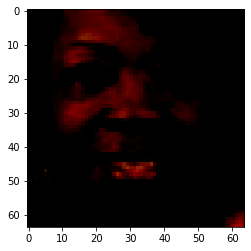

In [ ]:
plt.imshow((x_train[0].astype(np.float32) - 127.5) / 127.5)

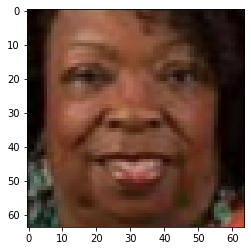

In [ ]:
plt.imshow(x_train[0])